<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
uploaded = files.upload()              # ← this pops up a file browser
df = pd.read_csv(next(iter(uploaded)))  # reads whichever file you pick


Saving heart_hotwired.csv to heart_hotwired.csv


In [ ]:
# ──────────────── IMPORTS ────────────────
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, optimizers

# ──────────────── PREPROCESS ────────────────
# assume df already loaded
df = df.drop(columns=['source']) \
       .rename(columns={'Presence of Heart Disease (1=Yes)': 'target'})

X = df.drop(columns=['target']).values
y = df['target'].values

# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ──────────────── MODEL BUILDER ────────────────
def build_model(input_dim):
    l2 = regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=l2),
        layers.Dense(1, activation='sigmoid')
    ])

    # lower learning rate, track AUC
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model(X_train.shape[1])

# ──────────────── CALLBACKS ────────────────
es = callbacks.EarlyStopping(
    monitor='val_auc',      # stop when AUC stops improving
    mode='max',             # we want to MAXIMIZE AUC
    patience=10,
    restore_best_weights=True
)

rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

# ──────────────── TRAIN ────────────────
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es, rlr],
    verbose=2
)

# ──────────────── EVALUATE ────────────────
loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}   |   Test accuracy: {acc:.4f}   |   Test AUC: {auc:.4f}")


Epoch 1/100
52/52 - 3s - 57ms/step - accuracy: 0.5675 - auc: 0.6121 - loss: 0.7025 - val_accuracy: 0.7885 - val_auc: 0.8660 - val_loss: 0.5674 - learning_rate: 1.0000e-03
Epoch 2/100
52/52 - 1s - 16ms/step - accuracy: 0.7398 - auc: 0.8100 - loss: 0.5581 - val_accuracy: 0.8029 - val_auc: 0.8925 - val_loss: 0.4505 - learning_rate: 1.0000e-03
Epoch 3/100
52/52 - 0s - 5ms/step - accuracy: 0.8024 - auc: 0.8547 - loss: 0.4782 - val_accuracy: 0.8269 - val_auc: 0.9061 - val_loss: 0.3988 - learning_rate: 1.0000e-03
Epoch 4/100
52/52 - 0s - 6ms/step - accuracy: 0.8048 - auc: 0.8830 - loss: 0.4344 - val_accuracy: 0.8221 - val_auc: 0.9093 - val_loss: 0.3810 - learning_rate: 1.0000e-03
Epoch 5/100
52/52 - 0s - 4ms/step - accuracy: 0.8265 - auc: 0.8897 - loss: 0.4222 - val_accuracy: 0.8462 - val_auc: 0.9155 - val_loss: 0.3701 - learning_rate: 1.0000e-03
Epoch 6/100
52/52 - 0s - 4ms/step - accuracy: 0.8265 - auc: 0.9003 - loss: 0.4088 - val_accuracy: 0.8413 - val_auc: 0.9192 - val_loss: 0.3567 - lear

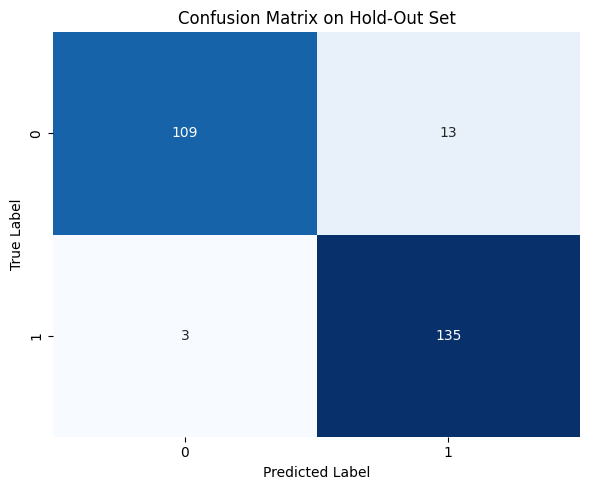

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ─── CONFIGURATION ─────────────────────────────────────────────────────────────
# Replace 'target' if your label column has a different name
label_col   = 'target'
feature_cols = [c for c in df.columns if c != label_col]
# ────────────────────────────────────────────────────────────────────────────────

# 1) Split data
df_train, df_holdout = train_test_split(df, test_size=0.2, random_state=42)

# 2) Extract arrays
X_train, y_train = df_train[feature_cols].values, df_train[label_col].values
X_hold,  y_hold  = df_holdout[feature_cols].values, df_holdout[label_col].values

# 3) Scale features
scaler = StandardScaler().fit(X_train)
X_hold_scaled = scaler.transform(X_hold)

# 4) Predict on hold-out
probs_hold = model.predict(X_hold_scaled, verbose=0).flatten()
preds_hold = (probs_hold >= 0.5).astype(int)

# 5) Compute confusion matrix
cm = confusion_matrix(y_hold, preds_hold)

# 6) Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Hold-Out Set')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Prepare your hold-out set exactly as you did for LIME
label_col    = 'target'
feature_cols = [c for c in df.columns if c != label_col]
df_train, df_holdout = train_test_split(df, test_size=0.2, random_state=42)

X_train = df_train[feature_cols].values; y_train = df_train[label_col].values
X_hold  = df_holdout[feature_cols].values; y_hold  = df_holdout[label_col].values

scaler = StandardScaler().fit(X_train)
X_hold_scaled = scaler.transform(X_hold)

# 2) Get model predictions
probs_hold = model.predict(X_hold_scaled, verbose=0).flatten()
preds_hold = (probs_hold >= 0.5).astype(int)

# 3) Compute metrics
print("=== Classification Report ===")
print(classification_report(y_hold, preds_hold, digits=3))

print("=== Other Metrics ===")
print(f"Accuracy : {accuracy_score(y_hold, preds_hold):.3f}")
print(f"AUC      : {roc_auc_score(y_hold, probs_hold):.3f}")
print(f"Log Loss : {log_loss(y_hold, probs_hold):.3f}")

# 4) Show confusion matrix for completeness
cm = confusion_matrix(y_hold, preds_hold)
print("Confusion Matrix:")
print(cm)


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.973     0.893     0.932       122
           1      0.912     0.978     0.944       138

    accuracy                          0.938       260
   macro avg      0.943     0.936     0.938       260
weighted avg      0.941     0.938     0.938       260

=== Other Metrics ===
Accuracy : 0.938
AUC      : 0.965
Log Loss : 0.226
Confusion Matrix:
[[109  13]
 [  3 135]]


In [ ]:
import shap

# Assuming the model and data are already available as per the user's code
# and that the user wants to generate a SHAP explanation for instance 40.

# Build SHAP explainer with the trained model
explainer = shap.KernelExplainer(model.predict, X_train)

# Select instance 40 for explanation
instance_40 = X_test[40].reshape(1, -1)




33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Generate SHAP values for instance 40
shap_values = explainer.shap_values(instance_40)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step


In [ ]:
import pandas as pd

# Extract feature names (excluding the label column)
feature_cols = [col for col in df.columns if col != label_col]

# Convert SHAP values into a DataFrame for instance 40
# Since shap_values[0] contains the SHAP values for a single instance,
# we convert the array into a 1D row and assign the feature names as columns
shap_values_df = pd.DataFrame(shap_values[0].T, columns=feature_cols)

# Display the SHAP values table
print(shap_values_df)


      Age  Resting Blood Pressure (mm Hg)  Serum Cholesterol (mg/dL)  \
0  0.0955                        0.032468                   0.369444   

   Maximum Heart Rate Achieved  ST Depression Induced by Exercise  \
0                    -0.489756                            0.03448   

   Sex: Female  Sex: Male  Chest Pain: Typical Angina  \
0          0.0        0.0                    0.020514   

   Chest Pain: Atypical Angina  Chest Pain: Non-Anginal  ...  \
0                          0.0                 0.040198  ...   

   ST Slope: Upsloping  ST Slope: Flat  ST Slope: Downsloping  \
0                  0.0        0.017495                    0.0   

   Thalassemia: Normal  Thalassemia: Fixed Defect  \
0                  0.0                        0.0   

   Thalassemia: Reversible Defect  Fluoroscopy: 0 Vessels  \
0                       -0.063379                     0.0   

   Fluoroscopy: 1 Vessel  Fluoroscopy: 2 Vessels  Fluoroscopy: 3 Vessels  
0                    0.0            

  0%|          | 0/260 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 83s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 84s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 83s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 81s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
68249/68249 ━━━━━━━━━━━━━━━━━━━━ 82s 1

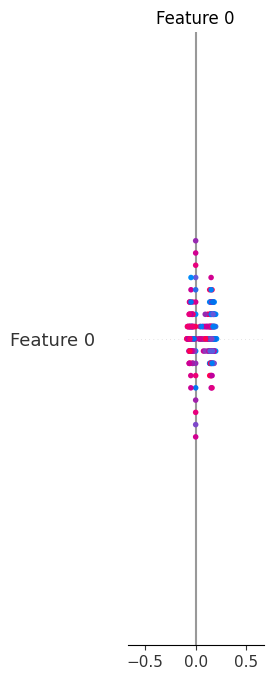

In [ ]:
# Ensure the SHAP values are computed for the correct data (X_test in this case)
shap_values = explainer.shap_values(X_test)

In [ ]:
import numpy as np

# Save SHAP values to a .npy file
np.save('shap_values.npy', shap_values)
from google.colab import files

# Download the file
files.download('shap_values.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

# Save SHAP values
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

# Download the file
files.download('shap_values.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(shap_values)  # This will give you the SHAP values for each instance and feature


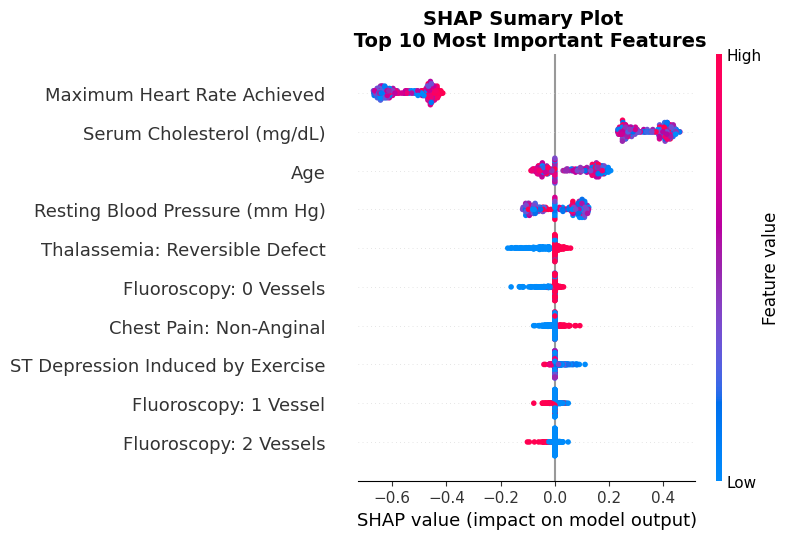

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure shap_values and X_test_df are defined
# shap_values = shap_values.squeeze(-1)
# X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Compute mean(|SHAP|) for top 10
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_10_indices = np.argsort(mean_abs_shap)[-10:]  # indices of top 10 features
top_10_features = [X_test_df.columns[i] for i in top_10_indices]

# Subset SHAP values and X_test_df for top 10 features
shap_values_top10 = shap_values[:, top_10_indices]
X_test_top10 = X_test_df[top_10_features]

# Plot summary with title
plt.figure()
shap.summary_plot(shap_values_top10, X_test_top10, show=False)
plt.title("SHAP Sumary Plot \n Top 10 Most Important Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


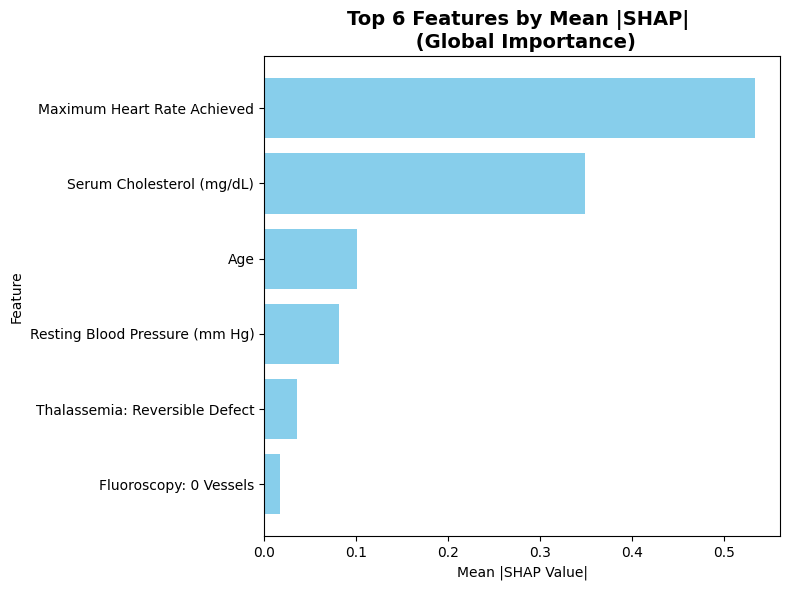

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Step 2: Create DataFrame sorted by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP|': mean_abs_shap
}).sort_values(by='Mean |SHAP|', ascending=False)  # descending for top-first

# Step 3: Take top 10
top_10_df = importance_df.head(6).sort_values(by='Mean |SHAP|', ascending=True)  # reverse for horizontal bar

# Step 4: Plot with proper title
plt.figure(figsize=(8, 6))
plt.barh(top_10_df['Feature'], top_10_df['Mean |SHAP|'], color='skyblue')
plt.title("Top 6 Features by Mean |SHAP| \n (Global Importance)", fontsize=14, fontweight='bold')
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute mean SHAP values (signed, not absolute)
mean_shap = shap_values.mean(axis=0)

# Step 2: Create DataFrame sorted by signed importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP': mean_shap
}).sort_values(by='Mean SHAP', key=lambda x: np.abs(x), ascending=False)

# Step 3: Take top 6 features by absolute mean SHAP
top_6_df = importance_df.head(6).sort_values(by='Mean SHAP')

# Step 4: Plot horizontal bar chart with signed values
plt.figure(figsize=(8, 6))
bars = plt.barh(top_6_df['Feature'], top_6_df['Mean SHAP'],
                color=['green' if val < 0 else 'red' for val in top_6_df['Mean SHAP']])
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Top 6 Features by Mean SHAP Value \n (Direction + Magnitude)", fontsize=14, fontweight='bold')
plt.xlabel("Mean SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


NameError: name 'shap_values' is not defined

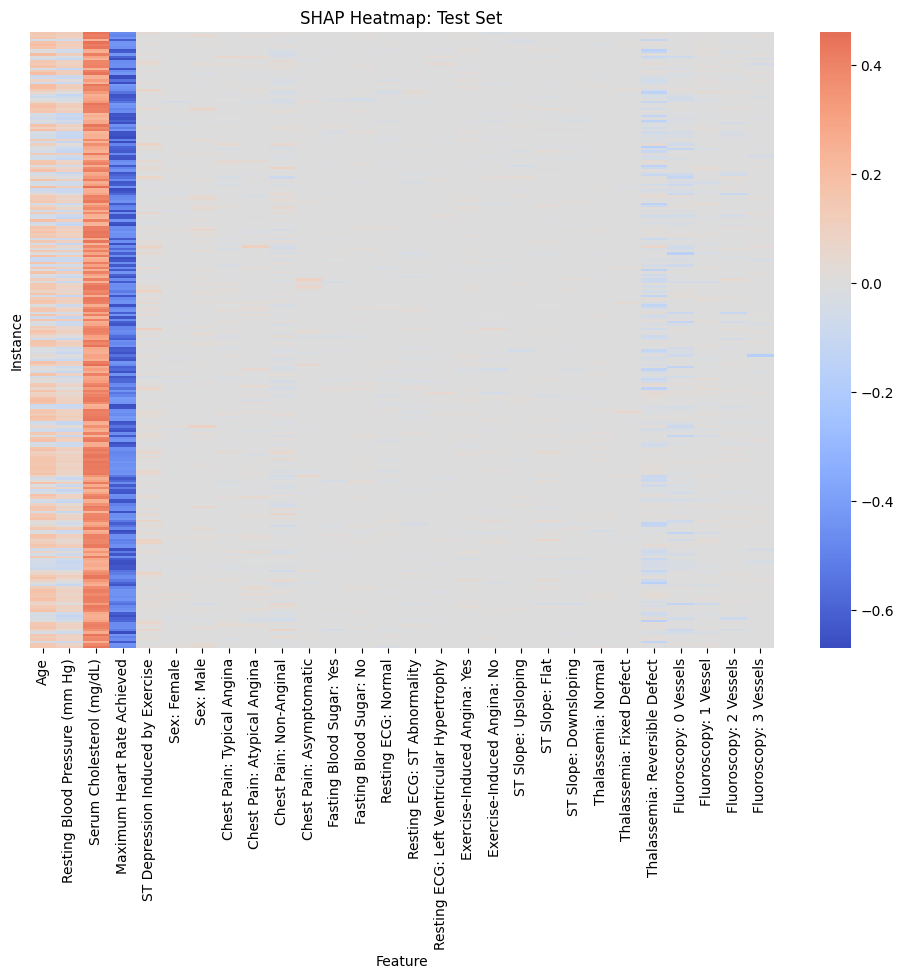

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(shap_values, xticklabels=feature_names, yticklabels=False, cmap='coolwarm', center=0)
plt.title("SHAP Heatmap: Test Set")
plt.xlabel("Feature")
plt.ylabel("Instance")
plt.show()


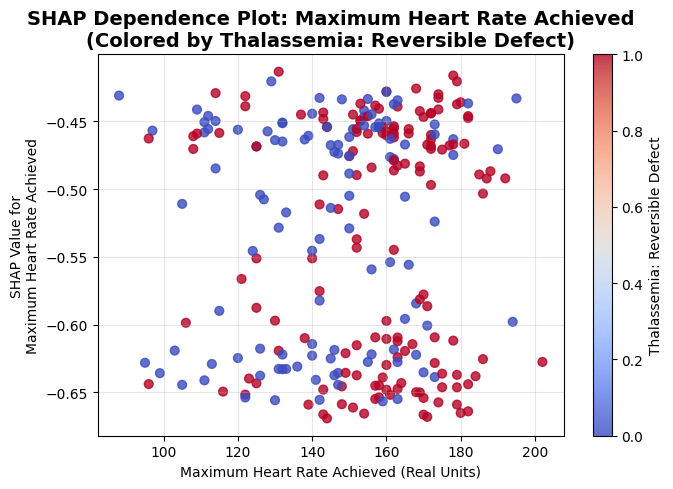

In [ ]:
import matplotlib.pyplot as plt

# Set target and interaction feature
target_feature = 'Maximum Heart Rate Achieved'
interaction_feature = 'Thalassemia: Reversible Defect'

# Get SHAP values for the target feature
feature_idx = feature_names.index(target_feature)
shap_vals = shap_values[:, feature_idx]

# Get real (unscaled) values from original df
x_real = df.loc[X_test_df.index, target_feature].values
interaction_vals = df.loc[X_test_df.index, interaction_feature].values

# Plot
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    x_real,
    shap_vals,
    c=interaction_vals,
    cmap='coolwarm',
    s=40,
    alpha=0.8
)
cbar = plt.colorbar(scatter)
cbar.set_label(interaction_feature)

plt.title(f"SHAP Dependence Plot: {target_feature}\n(Colored by {interaction_feature})", fontsize=14, fontweight='bold')
plt.xlabel(f"{target_feature} (Real Units)")
plt.ylabel(f"SHAP Value for\n{target_feature}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


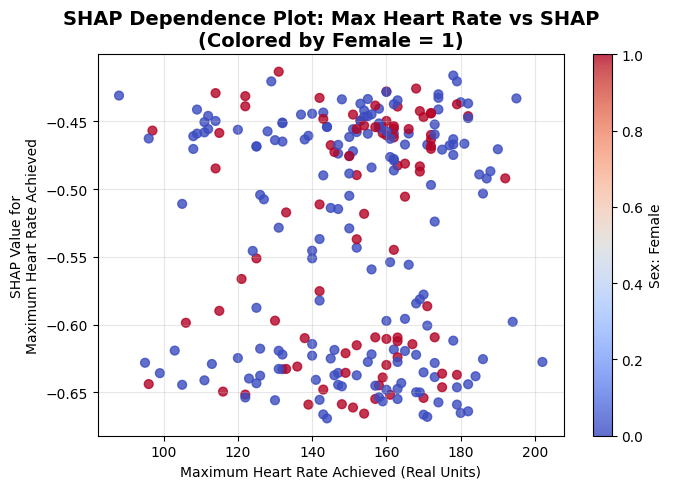

In [ ]:
import matplotlib.pyplot as plt

# Define target and interaction feature
target_feature = 'Maximum Heart Rate Achieved'
interaction_feature = 'Sex: Female'

# Get SHAP values for heart rate
feature_idx = feature_names.index(target_feature)
shap_vals = shap_values[:, feature_idx]

# Get real (unscaled) heart rate values
x_real = df.loc[X_test_df.index, target_feature].values
interaction_vals = df.loc[X_test_df.index, interaction_feature].values  # 0 = male, 1 = female

# Plot
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    x_real,
    shap_vals,
    c=interaction_vals,
    cmap='coolwarm',
    s=40,
    alpha=0.8
)
cbar = plt.colorbar(scatter)
cbar.set_label(interaction_feature)

plt.title("SHAP Dependence Plot: Max Heart Rate vs SHAP\n(Colored by Female = 1)", fontsize=14, fontweight='bold')
plt.xlabel("Maximum Heart Rate Achieved (Real Units)")
plt.ylabel("SHAP Value for\nMaximum Heart Rate Achieved")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


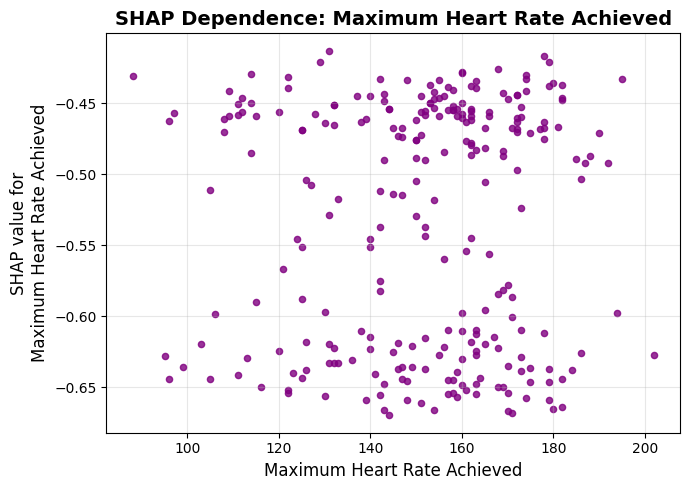

In [ ]:
import matplotlib.pyplot as plt

# Target feature
feature = 'Maximum Heart Rate Achieved'
feature_index = feature_names.index(feature)

# SHAP values and real feature values
shap_vals = shap_values[:, feature_index]
real_vals = df.loc[X_test_df.index, feature].values

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(real_vals, shap_vals, color='purple', s=20, alpha=0.8)

# Labels
plt.xlabel(feature, fontsize=12)
plt.ylabel(f"SHAP value for\n{feature}", fontsize=12)
plt.title(f"SHAP Dependence: {feature}", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


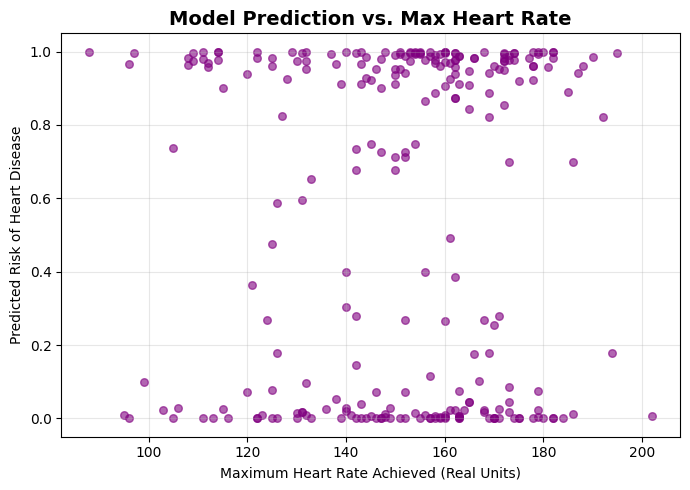

In [ ]:
y_pred = model.predict(X_test).flatten()  # Predicted probabilities from your NN
import matplotlib.pyplot as plt

real_heart_rate = df.loc[X_test_df.index, 'Maximum Heart Rate Achieved']

plt.figure(figsize=(7, 5))
plt.scatter(real_heart_rate, y_pred, color='purple', alpha=0.6, s=30)

plt.title("Model Prediction vs. Max Heart Rate", fontsize=14, fontweight='bold')
plt.xlabel("Maximum Heart Rate Achieved (Real Units)")
plt.ylabel("Predicted Risk of Heart Disease")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


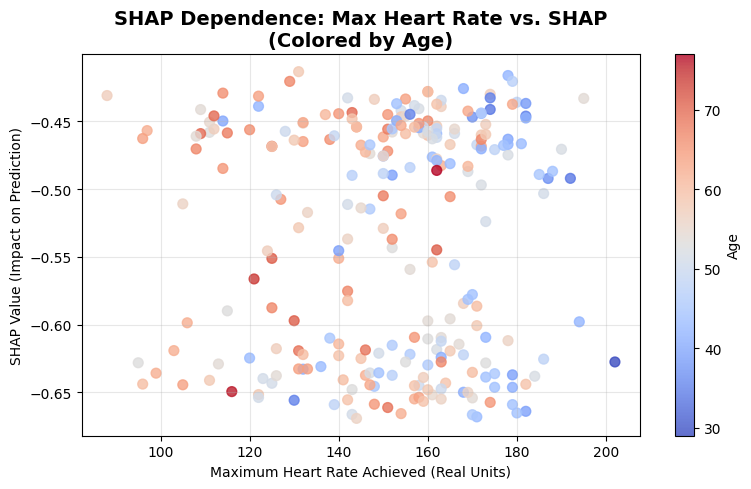

In [ ]:
import matplotlib.pyplot as plt

# Get feature values
x = df.loc[X_test_df.index, 'Maximum Heart Rate Achieved']
y = shap_values[:, feature_names.index('Maximum Heart Rate Achieved')]
interaction = df.loc[X_test_df.index, 'Age']  # color by Age

# Plot
plt.figure(figsize=(8, 5))
scatter = plt.scatter(x, y, c=interaction, cmap='coolwarm', s=50, alpha=0.8)
cbar = plt.colorbar(scatter)
cbar.set_label('Age')

plt.title("SHAP Dependence: Max Heart Rate vs. SHAP\n(Colored by Age)", fontsize=14, fontweight='bold')
plt.xlabel("Maximum Heart Rate Achieved (Real Units)")
plt.ylabel("SHAP Value (Impact on Prediction)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df.corr()['target'].sort_values(ascending=False)


,target
target,1.000000
Thalassemia: Reversible Defect,0.528184
Fluoroscopy: 0 Vessels,0.441624
Exercise-Induced Angina: No,0.355924
Maximum Heart Rate Achieved,0.354993
Sex: Female,0.278458
ST Slope: Downsloping,0.270110
Chest Pain: Non-Anginal,0.266406
Chest Pain: Atypical Angina,0.210478
Resting ECG: Left Ventricular Hypertrophy,0.083826


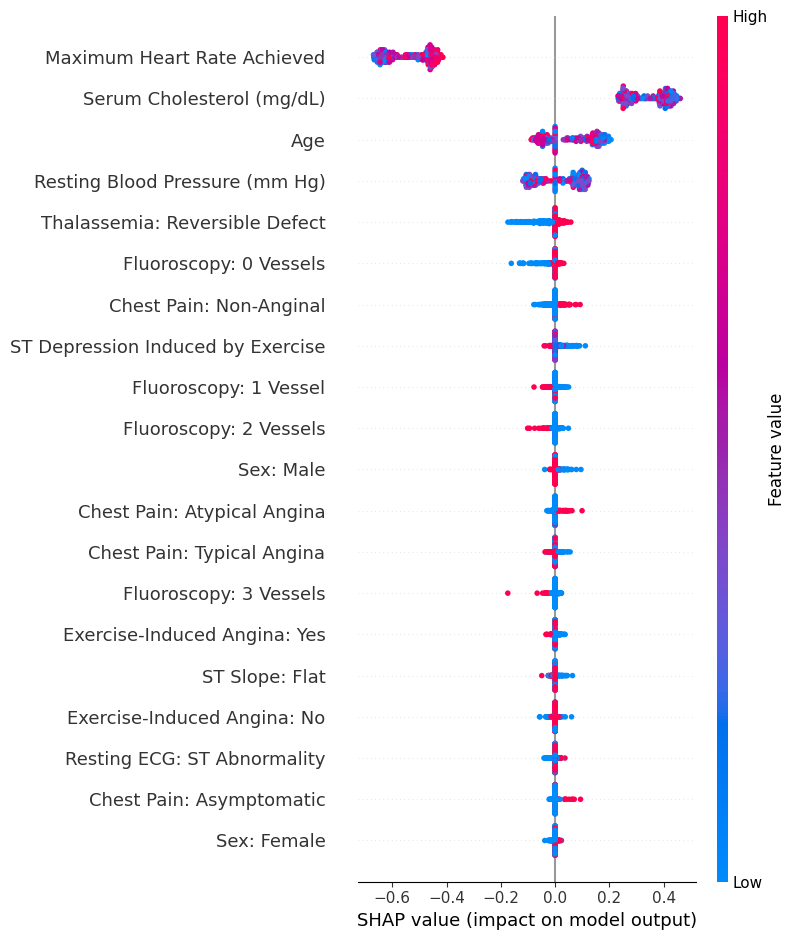

In [ ]:
shap.summary_plot(shap_values, X_test_df)
